In [1]:
import sys
sys.path.append('/ssd/kangdang/mmc_project_2023_submission/main_exp_code/step4_exp_analysis')

import pickle
import pandas as pd
import os
import os.path as pathlib
from stats_fun import cal_ci95
import sklearn.metrics as metrics
import numpy as np
import pickle 
import os.path as pathlib
from stats_fun import cal_ci95
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

output_dir = '/ssd/kangdang/mmc_project_2023_submission/main_exp_code/step4_exp_analysis/fig7/data'
os.makedirs(output_dir, exist_ok=True)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def get_score_and_gt_helper(input_dir, method_id, feature_id, fusion_type='metric_only', imputation_type='mi'):
    if imputation_type == 'mi':
        input_dir = pathlib.join(input_dir, method_id)
        val_pred_list = list()
        val_gt_list = list()
        val_id_list = list()
        test_pred_list = list()
        test_gt_list = list()
        test_id_list = list()
        for mice_id in range(20):
            curr_folder = pathlib.join(input_dir, 'mice_imputation_' + str(mice_id+ 1), fusion_type)
            val_score = pd.read_csv(pathlib.join(curr_folder, "feat_[" + str(feature_id) + "]_val_pred_result.csv"))
            test_score = pd.read_csv(pathlib.join(curr_folder, "feat_[" + str(feature_id) + "]_test_pred_result.csv"))
            val_pred_list.append(np.array(val_score['pred']))
            val_gt_list.append(np.array(val_score['gt']))
            test_pred_list.append(np.array(test_score['pred']))
            test_gt_list.append(np.array(test_score['gt']))
            val_id_list.append(np.array(val_score['patient_id']))
            test_id_list.append(np.array(test_score['patient_id']))
        val_gt_list = val_gt_list[0]
        test_gt_list = test_gt_list[0]
        val_id_list = val_id_list[0]
        test_id_list = test_id_list[0]
        val_pred_list = np.mean(np.array(val_pred_list), axis = 0)
        test_pred_list = np.mean(np.array(test_pred_list), axis = 0)
    else:
        curr_folder = pathlib.join(input_dir, method_id, fusion_type)
        val_score = pd.read_csv(pathlib.join(curr_folder, "feat_[" + str(feature_id) + "]_val_pred_result.csv"))
        test_score = pd.read_csv(pathlib.join(curr_folder, "feat_[" + str(feature_id) + "]_test_pred_result.csv"))
        val_pred_list = np.array(val_score['pred'])
        val_gt_list = np.array(val_score['gt'])
        test_pred_list = np.array(test_score['pred'])
        test_gt_list = np.array(test_score['gt'])
        val_id_list = np.array(val_score['patient_id'])
        test_id_list = np.array(test_score['patient_id'])
    return  val_gt_list, test_gt_list, val_pred_list, test_pred_list, val_id_list, test_id_list


def get_score_and_gt(input_dir, feature_id, fusion_type='metric_only', imputation_type='mi', method_id_list=['method_lr_basic']):
    val_auc_list = []
    for method_id in method_id_list:
        val_gt_list, test_gt_list, val_pred_list, test_pred_list, val_id_list, test_id_list = get_score_and_gt_helper(input_dir, method_id, feature_id, fusion_type, imputation_type)
        fpr, tpr, threshold = metrics.roc_curve(val_gt_list, val_pred_list)
        auc = metrics.auc(fpr, tpr)
        val_auc_list.append(auc)
    
    best_val_idx = np.argmax(val_auc_list)
    best_method_id = np.array(method_id_list)[best_val_idx]
    val_gt_list, test_gt_list, val_pred_list, test_pred_list, val_id_list, test_id_list = get_score_and_gt_helper(input_dir, best_method_id, feature_id, fusion_type, imputation_type)
    return best_method_id, val_gt_list, test_gt_list, val_pred_list, test_pred_list, val_id_list, test_id_list

In [3]:
def get_subgroup_table(input_dir, feature_id, fusion_type='metric_only', imputation_type='mi'):
    test_data_for_extracting_attribution = '/ssd/kangdang/mmc_project_2023_submission/main_exp_code/step1_preprocessing_redo/preprocessed_data/random_processed_final_csv/test_table_orig_random_12_vars_with_nan_intermediate_table_patient_level.csv'
    test_data_for_extracting_attribution = pd.read_csv(test_data_for_extracting_attribution)
    root_dir = '/ssd/kangdang/mmc_project_2023_submission/main_exp_code/step1_preprocessing_redo'
    hba1c_source_data = pd.read_excel(pathlib.join(root_dir, 'source_data', 'clinical_data_to_voxelcloud_1212.xlsx'))
    
    _, _, test_gt_set, _, test_pred_set, _, test_id_set = get_score_and_gt(input_dir, feature_id, fusion_type, imputation_type)
    subgroup_list = list()
    for row in test_data_for_extracting_attribution.itertuples():
        patient_id = row[1]
        left_image_quality = row[4]
        right_image_quality = row[5]
        if np.isnan(left_image_quality):
            left_image_quality = right_image_quality
        if np.isnan(right_image_quality):
            right_image_quality = left_image_quality   
        if left_image_quality == 0 and right_image_quality == 0:
            image_quality = 0
        elif left_image_quality == 1 and right_image_quality == 1:
            image_quality = 2
        else:
            image_quality = 1

        province = row[6]
        province_south = ['广东', '广西', '海南', '香港', '澳门', '四川', '贵州', '云南', '重庆', '西藏']
        if type(province) == float and np.isnan(province):
            province = '上海'
        if province in province_south:
            province_id = 1
        else:
            province_id = 0

        gender = row[7]
        age = 11.6 * row[8]  + 54.29
        hb1ac = hba1c_source_data[hba1c_source_data['编号']==patient_id]['变量15'].values[0]
        hb1ac = 2.27 * hb1ac + 9.06
        test_result_pickle_idx = np.nonzero(np.array(test_id_set) == patient_id)[0]
        if len(test_gt_set[test_result_pickle_idx]) == 1:
            test_gt = test_gt_set[test_result_pickle_idx][0]
            test_pred = test_pred_set[test_result_pickle_idx][0]
            subgroup_list.append((patient_id, image_quality, province_id, gender, age, hb1ac, test_gt, test_pred))
    subgroup_table = pd.DataFrame(subgroup_list, columns=('patient_id', 'image_quality', 'province_id', 'gender', 'age', 'hb1ac', 'test_gt', 'test_pred'))
    return subgroup_table

def save_merged_dataframe(input_dir, output_dir, metric_string, save_prefix_string, imputation_type, group_var, group_sep, desc_str_list, second_variable_name=None, second_variable_value=None):
    subgroup_table_metric_only = get_subgroup_table(input_dir, metric_string, "metric_only", imputation_type)
    subgroup_table_fusion = get_subgroup_table(input_dir, metric_string, "fusion", imputation_type)
    if second_variable_name is not None:
        subgroup_table_metric_only = subgroup_table_metric_only[subgroup_table_metric_only[second_variable_name]==second_variable_value]
        subgroup_table_fusion = subgroup_table_fusion[subgroup_table_fusion[second_variable_name]==second_variable_value]
    
    print(save_prefix_string)
    for subgroup_idx in range(len(group_sep) - 1):
        range_left = group_sep[subgroup_idx]
        range_right = group_sep[subgroup_idx + 1]
        curr_desc = desc_str_list[subgroup_idx]
        print(str(second_variable_name) + ', ' + str(second_variable_value) + ', ' + group_var + ', ' + str(range_left) + ', ' + str(range_right))
    
        print('metric_only, ' + curr_desc)
        curr_subgroup_metric_only = subgroup_table_metric_only[((subgroup_table_metric_only[group_var]>=range_left) & (subgroup_table_metric_only[group_var]<range_right))]
        test_gt_list0 = list(curr_subgroup_metric_only['test_gt'])
        test_pred_list0 = list(curr_subgroup_metric_only['test_pred'])
        auc95, rec, sep, sep_90, global_auc, global_rec, global_sep, global_sep_90, global_largest_youden_th_metric, global_given_recall_th_metric = cal_ci95(test_gt_list0, test_pred_list0, 0.8)
        fpr, tpr, threshold = metrics.roc_curve(test_gt_list0, test_pred_list0)
        auc = metrics.auc(fpr, tpr)
        print("[" + "{:.1f}".format(auc95[0] * 100) + "," + "{:.1f}".format(auc95[1] * 100) + "]")
        print("{:.1f}".format(auc * 100))

        print('fusion, ' + curr_desc)
        curr_subgroup_fusion = subgroup_table_fusion[((subgroup_table_fusion[group_var]>=range_left) & (subgroup_table_fusion[group_var]<range_right))]
        test_gt_list1 = list(curr_subgroup_fusion['test_gt'])
        test_pred_list1 = list(curr_subgroup_fusion['test_pred'])        
        auc95, rec, sep, sep_90, global_auc, global_rec, global_sep, global_sep_90, global_largest_youden_th_metric, global_given_recall_th_metric = cal_ci95(test_gt_list1, test_pred_list1, 0.8)
        print('sen=' + str(rec))
        print('global_sen=' + str(global_rec))
        print('sep=' + str(sep))
        print('global_sep=' + str(global_sep))

        fpr, tpr, threshold = metrics.roc_curve(test_gt_list1, test_pred_list1)
        auc = metrics.auc(fpr, tpr)
        print("[" + "{:.1f}".format(auc95[0] * 100) + "," + "{:.1f}".format(auc95[1] * 100) + "]")
        print("{:.1f}".format(auc * 100))
        print('')
        
        assert((np.array(test_gt_list0) == np.array(test_gt_list1)).all())
        merge_data_list = list()
        merge_data_list.append(test_gt_list0)
        merge_data_list.append(test_pred_list0)
        merge_data_list.append(test_pred_list1)
        merge_data_list = np.array(merge_data_list)
        merged_data_list = merge_data_list.transpose()

        merged_data_frame = pd.DataFrame(merged_data_list, columns=['target', 'metric', 'fusion'])
        save_name = save_prefix_string + ',subgroup_var=' + str(group_var) + ',desc=' + str(curr_desc) + '.csv'
        merged_data_frame.to_csv(pathlib.join(output_dir, save_name), index=False)

In [4]:
input_dir = '/mnt/eye_team/kangdang/mmc_project_2023_submission/exp_records/fusion_exps/random_mi'
metric_string = "'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'"
save_prefix_string = 'scenario_random_metric_and_fusion_mi'
imputation_type='mi'


group_var = 'age'
group_sep = [-1e6, 45, 60, 1e6]
desc_str_list= ['<45', '[45,60)', '>=60']

second_variable_name = 'gender'
second_variable_value = 1
desc_str_list= ['<45_gender=1', '[45,60)_gender=1', '>=60_gender=1']
save_merged_dataframe(input_dir, output_dir, metric_string, save_prefix_string, imputation_type, group_var, group_sep, desc_str_list, second_variable_name, second_variable_value)

second_variable_name = 'gender'
second_variable_value = 2
desc_str_list= ['<45_gender=2', '[45,60)_gender=2', '>=60_gender=2']
save_merged_dataframe(input_dir, output_dir, metric_string, save_prefix_string, imputation_type, group_var, group_sep, desc_str_list, second_variable_name, second_variable_value)

scenario_random_metric_and_fusion_mi
gender, 1, age, -1000000.0, 45
metric_only, <45_gender=1
[74.4,79.1]
76.8
fusion, <45_gender=1
sen=[0.7890295358649789, 0.8498896247240618]
global_sen=0.8209606986899564
sep=[0.5681818181818182, 0.6336]
global_sep=0.6016129032258064
[75.7,80.4]
78.1

gender, 1, age, 45, 60
metric_only, [45,60)_gender=1
[77.0,80.3]
78.7
fusion, [45,60)_gender=1
sen=[0.711340206185567, 0.7489851150202977]
global_sen=0.7312414733969986
sep=[0.6916802610114192, 0.75]
global_sep=0.7223088923556942
[78.1,81.4]
79.8

gender, 1, age, 60, 1000000.0
metric_only, >=60_gender=1
[74.6,81.6]
78.2
fusion, >=60_gender=1
sen=[0.7756539235412475, 0.8163265306122449]
global_sen=0.7963340122199593
sep=[0.5661764705882353, 0.7142857142857143]
global_sep=0.6416666666666666
[75.1,81.9]
78.6

scenario_random_metric_and_fusion_mi
gender, 2, age, -1000000.0, 45
metric_only, <45_gender=2
[79.4,86.0]
82.9
fusion, <45_gender=2
sen=[0.7375, 0.8461538461538461]
global_sen=0.7948717948717948
sep=[

In [11]:
input_dir = '/mnt/eye_team/kangdang/mmc_project_2023_submission/exp_records/fusion_exps/random_mi'
metric_string = "'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'"
save_prefix_string = 'scenario_random_metric_and_fusion_mi'
imputation_type='mi'

group_var = 'age'
group_sep = [-1e6, 60, 1e6]
desc_str_list= ['<60', '>=60']


second_variable_name = 'gender'
second_variable_value = 1
desc_str_list= ['<60_gender=1', '>=60_gender=1']
save_merged_dataframe(input_dir, output_dir, metric_string, save_prefix_string, imputation_type, group_var, group_sep, desc_str_list, second_variable_name, second_variable_value)

second_variable_name = 'gender'
second_variable_value = 2
desc_str_list= ['<60_gender=2',  '>=60_gender=2']
save_merged_dataframe(input_dir, output_dir, metric_string, save_prefix_string, imputation_type, group_var, group_sep, desc_str_list, second_variable_name, second_variable_value)

scenario_random_metric_and_fusion_mi
gender, 1, age, -1000000.0, 60
metric_only, <60_gender=1
[79.3,81.7]
80.6
fusion, <60_gender=1
sen=[0.7533678756476684, 0.7853403141361257]
global_sen=0.7692307692307693
sep=[0.687053216838761, 0.7282010997643362]
global_sep=0.7073750991276764
[80.1,82.7]
81.5

gender, 1, age, 60, 1000000.0
metric_only, >=60_gender=1
[74.6,81.6]
78.2
fusion, >=60_gender=1
sen=[0.7756539235412475, 0.8163265306122449]
global_sen=0.7963340122199593
sep=[0.5661764705882353, 0.7142857142857143]
global_sep=0.6416666666666666
[75.1,81.9]
78.6

scenario_random_metric_and_fusion_mi
gender, 2, age, -1000000.0, 60
metric_only, <60_gender=2
[81.7,84.9]
83.3
fusion, <60_gender=2
sen=[0.7045075125208681, 0.7467248908296943]
global_sen=0.7254901960784313
sep=[0.7675675675675676, 0.8197831978319783]
global_sep=0.7937853107344632
[82.4,85.5]
83.9

gender, 2, age, 60, 1000000.0
metric_only, >=60_gender=2
[71.3,79.7]
75.7
fusion, >=60_gender=2
sen=[0.7137546468401487, 0.75576036866359

In [12]:
input_dir = '/mnt/eye_team/kangdang/mmc_project_2023_submission/exp_records/fusion_exps/random_mi'
metric_string = "'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'"
save_prefix_string = 'scenario_random_metric_and_fusion_mi'
imputation_type='mi'

group_var = 'age'
group_sep = [-1e6, 45, 1e6]
desc_str_list= ['<45', '>=45']


second_variable_name = 'gender'
second_variable_value = 1
desc_str_list= ['<45_gender=1', '>=45_gender=1']
save_merged_dataframe(input_dir, output_dir, metric_string, save_prefix_string, imputation_type, group_var, group_sep, desc_str_list, second_variable_name, second_variable_value)

second_variable_name = 'gender'
second_variable_value = 2
desc_str_list= ['<45_gender=2',  '>=45_gender=2']
save_merged_dataframe(input_dir, output_dir, metric_string, save_prefix_string, imputation_type, group_var, group_sep, desc_str_list, second_variable_name, second_variable_value)

scenario_random_metric_and_fusion_mi
gender, 1, age, -1000000.0, 45
metric_only, <45_gender=1
[74.4,79.1]
76.8
fusion, <45_gender=1
sen=[0.7890295358649789, 0.8498896247240618]
global_sen=0.8209606986899564
sep=[0.5681818181818182, 0.6336]
global_sep=0.6016129032258064
[75.7,80.4]
78.1

gender, 1, age, 45, 1000000.0
metric_only, >=45_gender=1
[79.9,82.6]
81.3
fusion, >=45_gender=1
sen=[0.6783505154639176, 0.7090834697217676]
global_sen=0.6940359477124183
sep=[0.7761006289308177, 0.8233766233766234]
global_sep=0.8002628120893561
[80.7,83.4]
82.0

scenario_random_metric_and_fusion_mi
gender, 2, age, -1000000.0, 45
metric_only, <45_gender=2
[79.4,86.0]
82.9
fusion, <45_gender=2
sen=[0.7375, 0.8461538461538461]
global_sen=0.7948717948717948
sep=[0.7234726688102894, 0.8013029315960912]
global_sep=0.7645161290322581
[80.6,87.2]
84.1

gender, 2, age, 45, 1000000.0
metric_only, >=45_gender=2
[80.4,83.9]
82.2
fusion, >=45_gender=2
sen=[0.6938095238095238, 0.7284545016851228]
global_sen=0.711832

In [15]:
input_dir = '/mnt/eye_team/kangdang/mmc_project_2023_submission/exp_records/fusion_exps/random_mi'
metric_string = "'1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'"
save_prefix_string = 'scenario_random_metric_and_fusion_mi'
imputation_type='mi'

group_var = 'age'
group_sep = [-1e6, 45, 1e6]
desc_str_list= ['<45', '>=45']

save_merged_dataframe(input_dir, output_dir, metric_string, save_prefix_string, imputation_type, group_var, group_sep, desc_str_list, None, None)

scenario_random_metric_and_fusion_mi
None, None, age, -1000000.0, 45
metric_only, <45
[76.9,80.8]
78.9
fusion, <45
sen=[0.7504244482173175, 0.8053691275167785]
global_sen=0.7801302931596091
sep=[0.6627906976744186, 0.7105538140020898]
global_sep=0.6860215053763441
[78.3,81.9]
80.2

None, None, age, 45, 1000000.0
metric_only, >=45
[80.7,82.9]
81.8
fusion, >=45
sen=[0.7043189368770764, 0.7267518730718379]
global_sen=0.7152288732394366
sep=[0.7665016501650165, 0.8050713153724247]
global_sep=0.7860016090104586
[81.5,83.6]
82.5



In [8]:
import pickle
import pandas as pd
import os
import os.path as pathlib
from stats_fun import cal_ci95
import sklearn.metrics as metrics
import numpy as np
import pickle 
import os.path as pathlib
from stats_fun import cal_ci95
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def get_statistic_info(test_gt_list, test_pred_list):
    auc95, rec, sep, sep_90, global_auc, global_rec, global_sep, global_sep_90, _, _ = cal_ci95(test_gt_list, test_pred_list, 0.8)
    fpr, tpr, threshold = metrics.roc_curve(test_gt_list, test_pred_list)
    auc = metrics.auc(fpr, tpr)
    return auc95, fpr, tpr, auc

def get_subgroup_plot(save_name_list,  title_list, num):
    total_plots = len(save_name_list)
    my_dpi=96
    plt.figure(figsize=(int(480 * total_plots)/my_dpi, 480/my_dpi), dpi=my_dpi)
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')
    output_dir = '/ssd/kangdang/mmc_project_2023_submission/main_exp_code/step4_exp_analysis/fig7/data/'
    for idx, (save_name, title) in enumerate(zip(save_name_list,  title_list)):
        pd_table = pd.read_csv(pathlib.join(output_dir, save_name))
        auc95_metric, fpr_metric, tpr_metric, auc_metric = get_statistic_info(pd_table['target'], pd_table['metric'])
        auc95_fusion, fpr_fusion, tpr_fusion, auc_fusion = get_statistic_info(pd_table['target'], pd_table['fusion'])

        plt.subplot(1, total_plots, idx + 1)
        fpr = fpr_metric
        tpr = tpr_metric
        auc = auc_metric
        auc95 = auc95_metric
        label = 'clinical factor (N=' + str(num) + ')' + '\nAUC= ' + "{:.3f}".format(auc) + '[{:.3f}'.format(auc95[0]) + ',{:.3f}'.format(auc95[1]) + ']'
        plt.plot(fpr, tpr, marker='', color='plum', linewidth=3, alpha=0.7, label=label)

        fpr = fpr_fusion
        tpr = tpr_fusion
        auc = auc_fusion
        auc95 = auc95_fusion
        label = 'fusion (N=' + str(num) + ')' + '\nAUC= ' + "{:.3f}".format(auc) + '[{:.3f}'.format(auc95[0]) + ',{:.3f}'.format(auc95[1]) + ']'
        plt.plot(fpr, tpr, marker='', color='orange', linewidth=3, alpha=0.7, label=label)
        plt.xlim([0, 1.0])
        plt.ylim([0, 1.0])
        
        
        plt.legend(prop={'size': 14})
        plt.title(title, loc='left', fontsize=16, fontweight=0, color='black')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        ax=plt.gca()
        ax.xaxis.label.set_fontsize(16)
        ax.yaxis.label.set_fontsize(16)

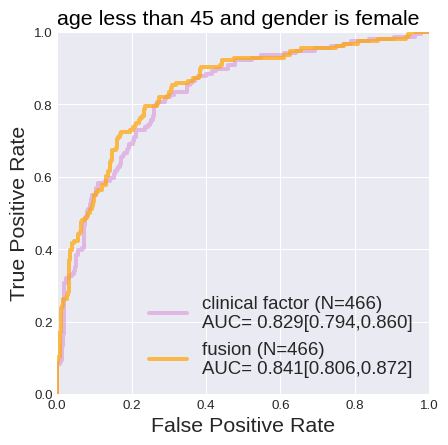

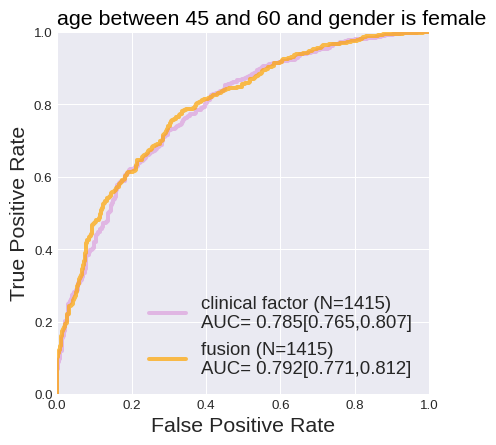

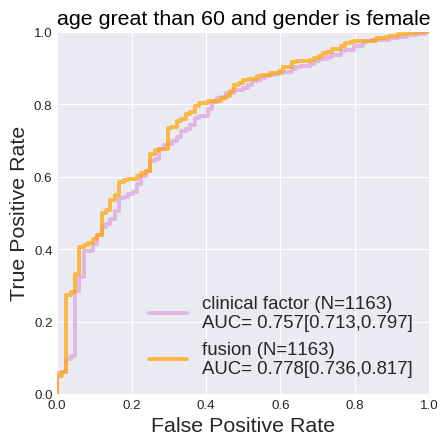

In [9]:
output_dir = '/ssd/kangdang/mmc_project_2023_submission/main_exp_code/step4_exp_analysis/fig7/data/'
save_name_list = ['scenario_random_metric_and_fusion_mi,subgroup_var=age,desc=<45_gender=2.csv']
num = len(pd.read_csv(pathlib.join(output_dir, save_name_list[0])))
title_list=['age less than 45 and gender is female'] 
get_subgroup_plot(save_name_list,  title_list, num)

save_name_list = ['scenario_random_metric_and_fusion_mi,subgroup_var=age,desc=[45,60)_gender=2.csv']
num = len(pd.read_csv(pathlib.join(output_dir, save_name_list[0])))
title_list=['age between 45 and 60 and gender is female'] 
get_subgroup_plot(save_name_list,  title_list, num)

save_name_list = ['scenario_random_metric_and_fusion_mi,subgroup_var=age,desc=>=60_gender=2.csv']
num = len(pd.read_csv(pathlib.join(output_dir, save_name_list[0])))
title_list=['age great than 60 and gender is female'] 
get_subgroup_plot(save_name_list,  title_list, num)

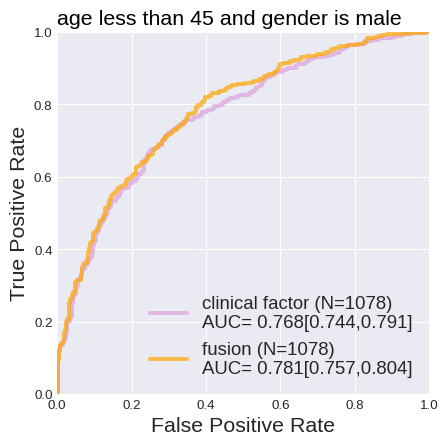

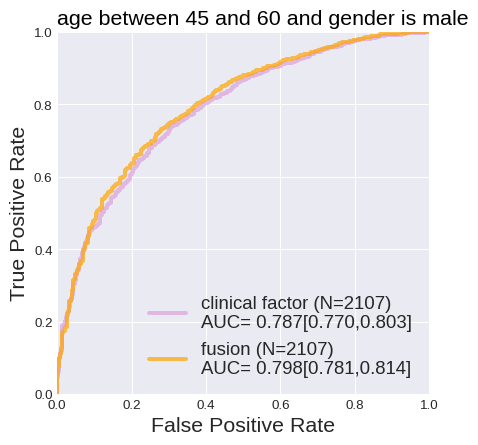

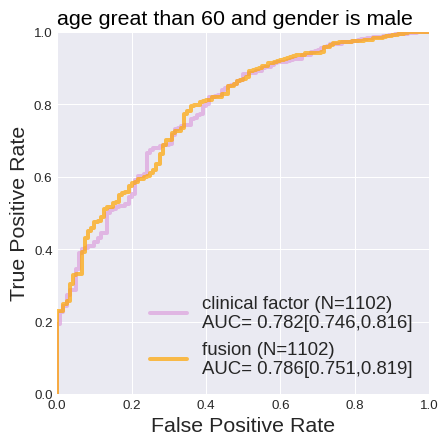

In [10]:
save_name_list = ['scenario_random_metric_and_fusion_mi,subgroup_var=age,desc=<45_gender=1.csv']
num = len(pd.read_csv(pathlib.join(output_dir, save_name_list[0])))
title_list=['age less than 45 and gender is male'] 
get_subgroup_plot(save_name_list,  title_list, num)


save_name_list = ['scenario_random_metric_and_fusion_mi,subgroup_var=age,desc=[45,60)_gender=1.csv']
num = len(pd.read_csv(pathlib.join(output_dir, save_name_list[0])))
title_list=['age between 45 and 60 and gender is male'] 
get_subgroup_plot(save_name_list,  title_list, num)

save_name_list = ['scenario_random_metric_and_fusion_mi,subgroup_var=age,desc=>=60_gender=1.csv']
num = len(pd.read_csv(pathlib.join(output_dir, save_name_list[0])))
title_list=['age great than 60 and gender is male'] 
get_subgroup_plot(save_name_list,  title_list, num)

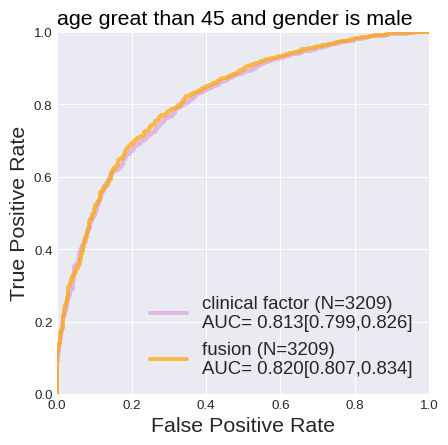

In [13]:
save_name_list = ['scenario_random_metric_and_fusion_mi,subgroup_var=age,desc=>=45_gender=1.csv']
num = len(pd.read_csv(pathlib.join(output_dir, save_name_list[0])))
title_list=['age great than 45 and gender is male'] 
get_subgroup_plot(save_name_list,  title_list, num)

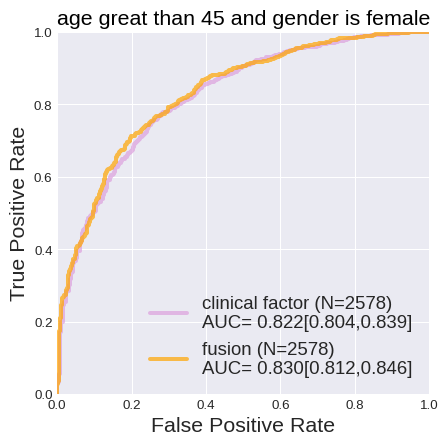

In [14]:
save_name_list = ['scenario_random_metric_and_fusion_mi,subgroup_var=age,desc=>=45_gender=2.csv']
num = len(pd.read_csv(pathlib.join(output_dir, save_name_list[0])))
title_list=['age great than 45 and gender is female'] 
get_subgroup_plot(save_name_list,  title_list, num)